In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import sys
import os

sys.path.append('..')
from counting_datasets.CityCam import CityCam, ToTensor
import metrics.counting_metrics as cm
from models.mcnn import MCNN

In [2]:
# Global variables
use_gpu = torch.cuda.is_available()
checkpoint_path = '../checkpoints/Epochs-50_BatchSize-8_LR-1e-06_Momentum-0.95_Gamma-0.5_Version-1/best_model.pt'
device = torch.device('cuda:0' if use_gpu else 'cpu')

In [3]:
def infer(sample):
    model = MCNN()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    img = sample['image']
    density_map = sample['density_map']
    gt_count = sample['gt_count']
    
    # make img's dimension (1, C, H, W)
    img = torch.unsqueeze(img, dim=0)
    # make the dimension of the density map (1, H, W)
    density_map = torch.unsqueeze(density_map, dim=0)
    
    img = img.to(device)
    density_map = density_map.to(device)
    
    with torch.set_grad_enabled(False):
        et_dm = model(img)
        down_sample = nn.Sequential(nn.MaxPool2d(2), nn.MaxPool2d(2))
        down_gt_dm = down_sample(density_map)

        et_dm = et_dm.cpu().numpy()
        down_gt_dm = down_gt_dm.cpu().numpy()
    
    print(f'The integral of the estimated density map: {et_dm.sum()}')
    print(f'The integral of the down-sampled GT density map: {down_gt_dm.sum()}')
    print(f'The integral of the GT density map {density_map.sum()}')
    
    return torch.squeeze(img, dim=0).cpu().numpy(), et_dm, down_gt_dm, gt_count

### Instanciate the CityCam dataset 

In [4]:
data_trans = transforms.Compose([ToTensor()])
cc = CityCam('../CityCam', dataset_type='Test', transform=data_trans)

### Plot a picture

In [5]:
len(cc)

8395

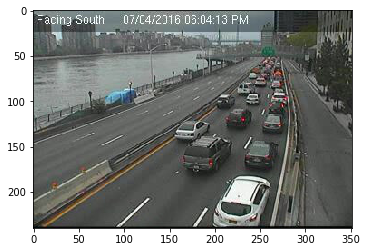

In [22]:
og_img = cc[8020]['image']
og_img = og_img.numpy().transpose(1, 2, 0)
plt.imshow(og_img)

### Ground-True vehicle num

In [23]:
cc[8020]['gt_count']

22

In [24]:
img, et_dm, gt_dm, gt_count = infer(cc[8020])

The integral of the estimated density map: 1.5805788040161133
The integral of the down-sampled GT density map: 2.0022687911987305
The integral of the GT density map 21.999998092651367


### Estimated density map (down-sampled)

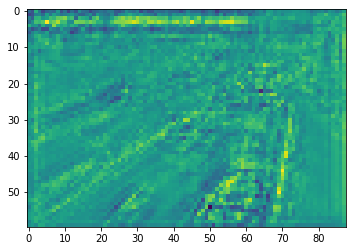

In [25]:
plt.imshow(et_dm.squeeze())

### Ground-True density map (down-sampled)

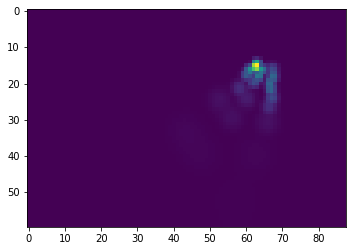

In [26]:
plt.imshow(gt_dm.squeeze())